# Laboratory Work: Image Processing with Convolution and Filters

In [1]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import transforms

# Реалізація операції згортки для матриці з нуля за допомогою NumPy
def convolve2D(image, kernel, stride=1, padding=0):
    image_padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
    output_dim = ((image.shape[0] - kernel.shape[0] + 2 * padding) // stride) + 1
    output = np.zeros((output_dim, output_dim))

    for y in range(0, image_padded.shape[0] - kernel.shape[0] + 1, stride):
        for x in range(0, image_padded.shape[1] - kernel.shape[1] + 1, stride):
            output[y // stride, x // stride] = np.sum(
                image_padded[y:y + kernel.shape[0], x:x + kernel.shape[1]] * kernel)

    return output
    

In [2]:

# Тестовий приклад для згортки
image_example = np.array([[45, 63, 27], [36, 18, 81], [9, 54, 72]])
kernel = np.ones((3, 3)) / 9  # Box-фільтр
output_example = convolve2D(image_example, kernel)
print("Згортка матриці:\n", output_example)
    

Згортка матриці:
 [[45.]]


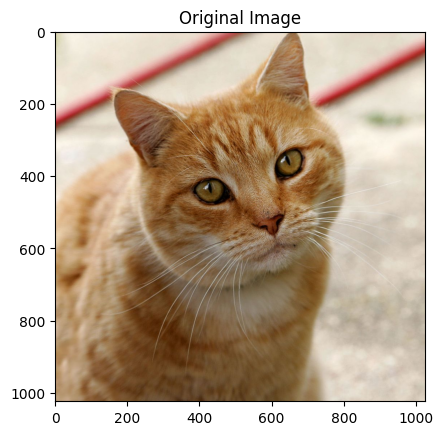

In [3]:

# Зчитування зображення за допомогою OpenCV
image_bgr = cv2.imread('Cat.jpg')
if image_bgr is None:
    print("Помилка: зображення не завантажилося. Перевірте шлях до файлу.")
else:
    # Перетворення з BGR в RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Відображаємо оригінальне зображення
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.show()

    # Перетворення зображення в тензор для подальшої роботи з PyTorch
    transform = transforms.ToTensor()
    image_tensor = transform(image_rgb).unsqueeze(0)  # Додаємо batch dimension
    

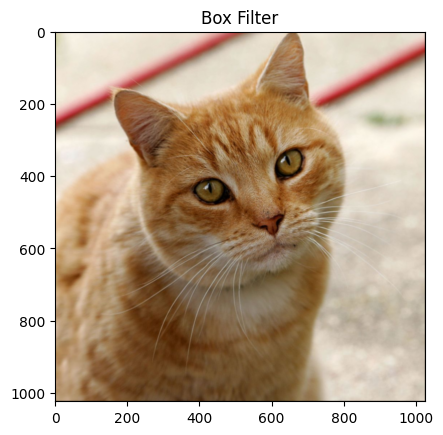

In [4]:

    # Ядро для box-фільтру (одне для кожного каналу)
    box_kernel = torch.ones((1, 1, 3, 3)) / 9  # Ядро для одного каналу
    box_kernel = box_kernel.repeat(3, 1, 1, 1)  # Повторюємо для 3 каналів (R, G, B)

    # Застосування box-фільтру
    image_filtered = F.conv2d(image_tensor, box_kernel, padding=1, groups=3)  # groups=3 для 3 каналів

    # Відображення результату box-фільтру
    image_filtered_np = image_filtered.squeeze(0).permute(1, 2, 0).numpy()
    image_filtered_np = np.clip(image_filtered_np, 0, 1)
    plt.imshow(image_filtered_np)
    plt.title('Box Filter')
    plt.show()
    

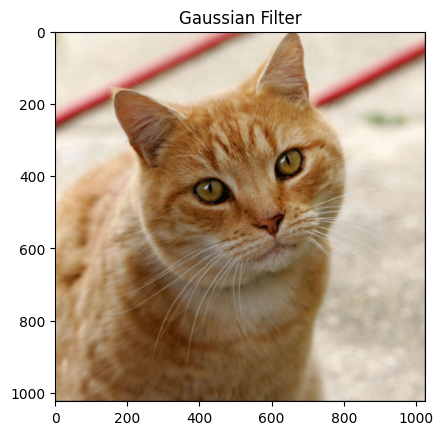

In [5]:

    # Реалізація фільтра Гауса
    gaussian_kernel = torch.tensor([
        [1, 4, 7, 4, 1],
        [4, 16, 26, 16, 4],
        [7, 26, 41, 26, 7],
        [4, 16, 26, 16, 4],
        [1, 4, 7, 4, 1]
    ], dtype=torch.float32) / 273.0

    gaussian_kernel = gaussian_kernel.view(1, 1, 5, 5).repeat(3, 1, 1, 1)
    gaussian_image = F.conv2d(image_tensor, gaussian_kernel, padding=2, groups=3)
    gaussian_image_np = gaussian_image.squeeze(0).permute(1, 2, 0).detach().numpy()
    gaussian_image_np = np.clip(gaussian_image_np, 0, 1)
    plt.imshow(gaussian_image_np)
    plt.title('Gaussian Filter')
    plt.show()
    

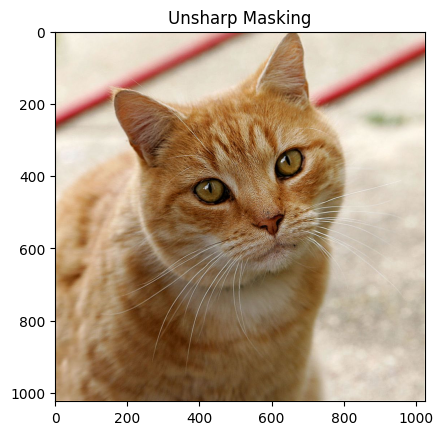

In [6]:

    # Реалізація unsharp masking
    unsharp_mask = image_tensor - gaussian_image
    unsharp_image = image_tensor + unsharp_mask
    unsharp_image_np = unsharp_image.squeeze(0).permute(1, 2, 0).detach().numpy()
    unsharp_image_np = np.clip(unsharp_image_np, 0, 1)
    plt.imshow(unsharp_image_np)
    plt.title('Unsharp Masking')
    plt.show()
    

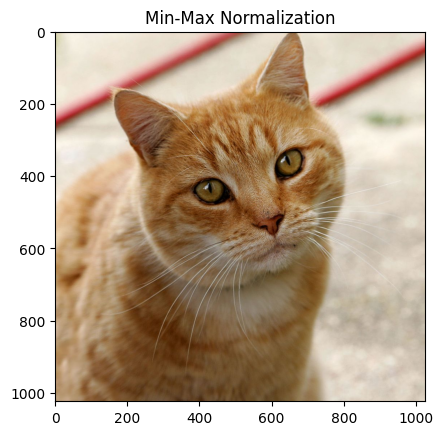

In [7]:

    # Нормалізація зображення (Min-Max)
    image_min = torch.min(image_tensor)
    image_max = torch.max(image_tensor)
    image_normalized = (image_tensor - image_min) / (image_max - image_min)
    image_normalized_np = image_normalized.squeeze(0).permute(1, 2, 0).numpy()
    plt.imshow(image_normalized_np)
    plt.title('Min-Max Normalization')
    plt.show()
    

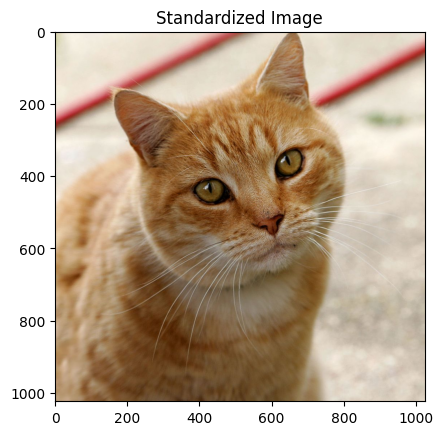

In [8]:

    # Стандартизація зображення
    mean = torch.mean(image_tensor)
    std = torch.std(image_tensor)
    image_standardized = (image_tensor - mean) / std
    image_standardized_np = image_standardized.squeeze(0).permute(1, 2, 0).numpy()
    image_standardized_np = (image_standardized_np - np.min(image_standardized_np)) / (
                np.max(image_standardized_np) - np.min(image_standardized_np))
    plt.imshow(image_standardized_np)
    plt.title('Standardized Image')
    plt.show()
    

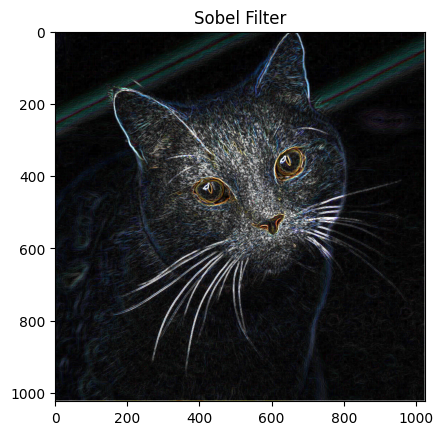

In [9]:

# Оператор Собеля для виявлення границь
sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32)

# Перетворення ядра в тензор для застосування до зображення з 3 каналами
sobel_x = sobel_x.view(1, 1, 3, 3).repeat(3, 1, 1, 1)
sobel_y = sobel_y.view(1, 1, 3, 3).repeat(3, 1, 1, 1)

# Застосування оператора Собеля
sobel_image_x = F.conv2d(image_tensor, sobel_x, padding=1, groups=3)
sobel_image_y = F.conv2d(image_tensor, sobel_y, padding=1, groups=3)

# Об'єднання результатів у фінальне зображення
sobel_image = torch.sqrt(sobel_image_x ** 2 + sobel_image_y ** 2)

# Відображення результату оператора Собеля
sobel_image_np = sobel_image.squeeze(0).permute(1, 2, 0).detach().numpy()
sobel_image_np = np.clip(sobel_image_np, 0, 1)

plt.imshow(sobel_image_np)
plt.title('Sobel Filter')
plt.show()
